In [18]:
import numpy as np
from sklearn import metrics
from utils import read_dataset
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv('pose_landmarks.csv')
x, y = read_dataset(dataset)  
X = x.reshape((7052, 33 * 3))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2, shuffle=True) 


In [29]:
model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)
train_acc  = model.score(X_train, y_train, sample_weight=None)
print("The Accuracy for Training Set is {}".format(train_acc*100))
y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

# cv = KFold(n_splits=5, random_state=1, shuffle=True)
# model = LogisticRegression(solver="saga", max_iter=3000)
# scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


The Accuracy for Training Set is 65.21081489884666
The Accuracy for Test Set is 63.01758366420873


The depth-14 tree achieves the best mean cross-validation accuracy 64.17088 +/- 0.94286% on training dataset
Single tree depth:  14
Accuracy, Training Set:  96.44545 %
Accuracy, Test Set:  63.92513 %


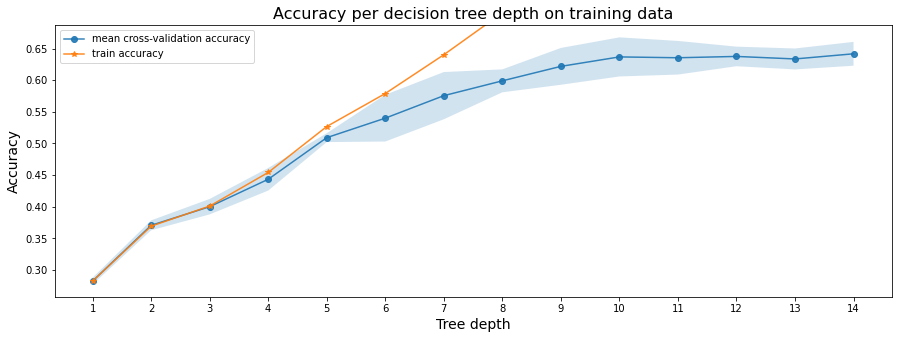

In [28]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
  cv_scores_list = []
  cv_scores_std = []
  cv_scores_mean = []
  accuracy_scores = []
  for depth in tree_depths:
      tree_model = DecisionTreeClassifier(max_depth=depth)
      cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
      cv_scores_list.append(cv_scores)
      cv_scores_mean.append(cv_scores.mean())
      cv_scores_std.append(cv_scores.std())
      accuracy_scores.append(tree_model.fit(X, y).score(X, y))
  cv_scores_mean = np.array(cv_scores_mean)
  cv_scores_std = np.array(cv_scores_std)
  accuracy_scores = np.array(accuracy_scores)
  return cv_scores_mean, cv_scores_std, accuracy_scores

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 14
sm_tree_depths = range(1,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

# function for training and evaluating a tree
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test
  

# train and evaluate a 5-depth tree
sm_best_tree_accuracy_train, sm_best_tree_accuracy_test = run_single_tree(X_train, y_train, 
                                                                          X_test, y_test, 
                                                                          sm_best_tree_depth)



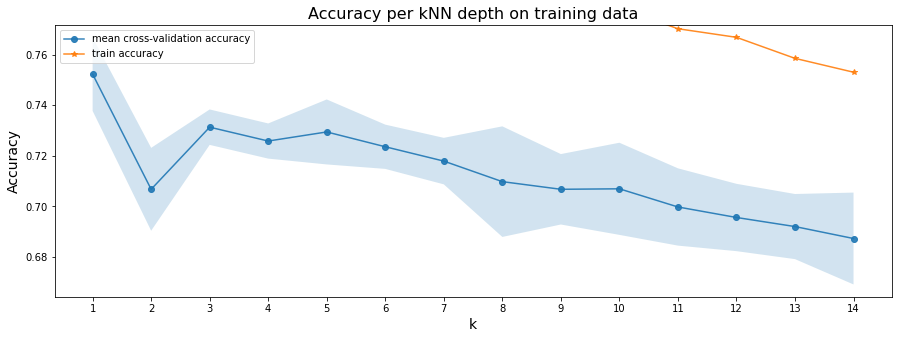

In [30]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation(X, y, k_list, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for k in k_list:
        KNN = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(KNN, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(KNN.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation(k_list, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(k_list, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(k_list, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(k_list, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('k', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(k_list)
    ax.legend()

# fitting trees of depth 1 to 15
k_list = range(1,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation(X_train, y_train, k_list)

# plotting accuracy
plot_cross_validation(k_list, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per kNN depth on training data')

In [27]:
def run_single(X_train, y_train, X_test, y_test, k):
    KNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    accuracy_train = KNN.score(X_train, y_train)
    accuracy_test = KNN.score(X_test, y_test)
    print('Single KNN: ', k)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return KNN
  

# train and evaluate a kNN
model = run_single(X_train, y_train, X_test, y_test, 1)

Single KNN:  2
Accuracy, Training Set:  86.2734 %
Accuracy, Test Set:  73.51106 %


In [23]:
import pickle
filename = 'model.sav'
pickle.dump(model, open("model/" + filename, 'wb'))